In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as st
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import itertools
from itertools import product

def read_csv(filepath):
    df = pd.read_csv(filepath, skiprows=0, error_bad_lines=False)
    df = df.iloc[::-1]#.reset_index()
    df.index = range(0, len(list(df.index)))
    return df

Gas_Data = read_csv('/Users/siddharth/Downloads/School Stuff/RBOB UGA/Gas_Data.csv')
#Gas_Data = Gas_Data.drop(labels='UGA_Close', axis=1)
Gas_Data.tail()

,Week of,All_Forms_Prices,Cushing_Crude_Futures,NY_Heating_Futures,NY_RBOB_Futures,Crude_Distillation_Capacity,Commercial_Crude_Imports,Days_of_Supply,Fuel_Ethanol_Ending,Blending_Components_Ending,...,Motor_Gasoline_Exports,RBOB_Blending_Imports,Total_Imports,Fuel_Ethanol_Production,Refinery_Utilization_Capacity,Motor_Gasoline_Supplied,Propane_Propylene_Supplied,Blending_Components_Inputs,Refinery_Crude_Inputs,Motor_Gasoline_Production
583,9/13/21,3.262,68.88,2.130,2.129,18128,5761,23.2,20010,200707,...,634,146,638,937,82.1,8892,888,557,14387,9565
584,9/20/21,3.280,71.62,2.189,2.178,18128,6465,24.0,20111,201312,...,621,187,1082,926,87.5,8896,1293,401,15347,9613
585,9/27/21,3.271,72.07,2.212,2.141,18128,6552,24.1,20220,202386,...,725,262,989,914,88.1,9399,1102,653,15415,9738
586,10/4/21,3.285,75.33,2.324,2.232,18128,7035,24.6,19931,207492,...,404,184,1088,978,89.6,9427,1281,532,15744,9745
587,10/11/21,3.360,78.33,2.461,2.335,18129,5994,24.2,19847,206846,...,699,211,543,1032,86.7,9186,1116,559,15061,9699


In [2]:
new_data = Gas_Data[['All_Forms_Prices', 'Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']]

scale_vars = ['Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']
scaler = MinMaxScaler()
new_data[scale_vars] = scaler.fit_transform(new_data[scale_vars])

<ipython-input-2-2b89591d089b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[scale_vars] = scaler.fit_transform(new_data[scale_vars])
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<AxesSubplot:>

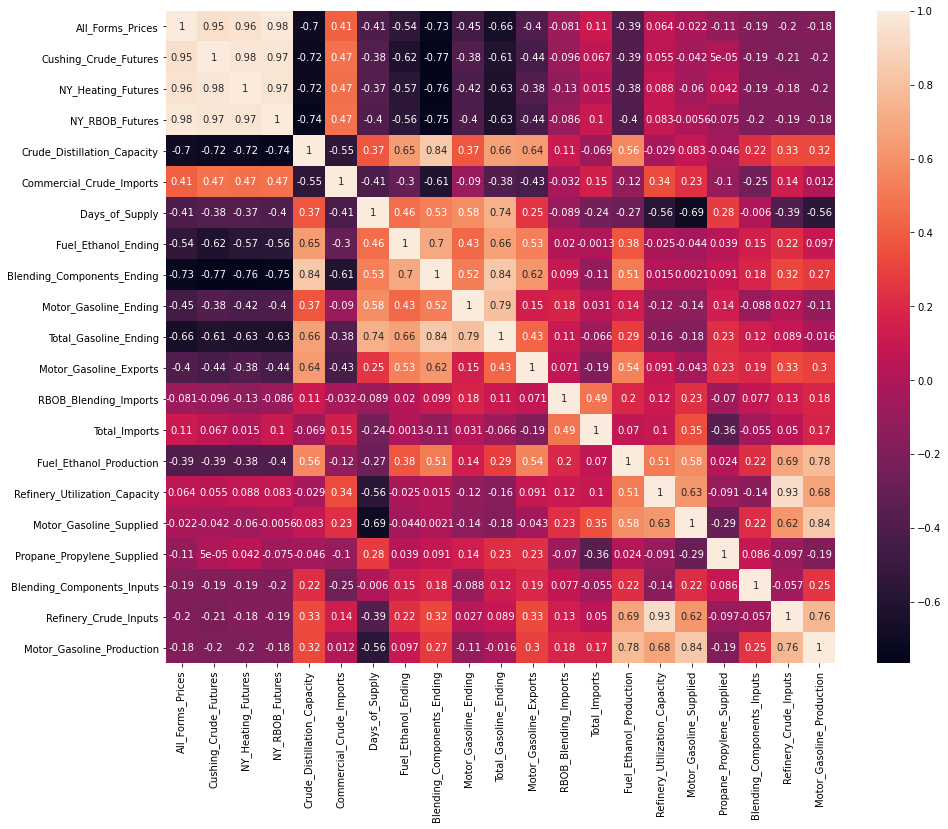

In [3]:
# Use a correlation heatmap to observe correlation
corr = new_data.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True)

In [4]:
# Splitting data into x and y

# Input features (attributes)
X = new_data.drop('All_Forms_Prices', axis=1).values
# Target vector
Y = new_data['All_Forms_Prices'].values

print('X shape: {}'.format(np.shape(X)))
print('Y shape: {}'.format(np.shape(Y)))

'''
Hold-Out Validation
- use 90% of data to train the model
- use 10% to test, bc model has not seen this data
- allows us to select and compare the best model
'''
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, random_state=0)

X shape: (588, 20)
Y shape: (588,)


In [5]:
reg = SVR(kernel='rbf')
reg = reg.fit(X_train, Y_train)

#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [6]:
# Accuracy on Train
print("Training Accuracy is: ", reg.score(X_train, Y_train))

# Accuracy on Test
print("Testing Accuracy is: ", reg.score(X_test, Y_test))

Training Accuracy is:  0.9857951774621907
Testing Accuracy is:  0.9805364295930854


In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
degrees = [2,3,4,5]
epsilons = [0.005, 0.01, 0.015, 0.02]
'''
# We can iterate through all possible combinations with product
for k,d,e in product(kernels, degrees, epsilons):
    reg = SVR(kernel=kernels, degree=degrees, epsilon=epsilons)
    reg = reg.fit(X_train, Y_train)
    prediction_test = reg.predict(X=X_test)
    print(f"Params: K={k}, D={d}, S={str(s)}, E={e}")
    print(f"Accuracy Score: {accuracy_score(Y_test,prediction_test)}")
    print(f"Training Accuracy: {reg.score(X_train, Y_train)}, Testing Accuracy: {reg.score(X_test, Y_test)}")
'''
param_range = [0.005, 0.01, 0.015, 0.02]

train_scores, test_scores = validation_curve(SVR(), X, Y, param_name="epsilon", param_range=param_range, n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVR")
plt.xlabel(r"$\kernel$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [7]:
pred_svr = reg.predict(X)

In [8]:
svr_cv_score = cross_val_score(reg, X, pred_svr)
print("Cross Validation Scores: ",svr_cv_score)
print("Median: ",st.median(svr_cv_score))
print("Stdv: ",svr_cv_score.std())
print(reg.score(X,pred_svr))

Cross Validation Scores:  [0.76951842 0.83848939 0.69057292 0.94333076 0.46630963]
Median:  0.7695184207037219
Stdv:  0.16077987092999374
1.0


In [9]:
from numpy import prod

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50],
    "max_depth":[2,3,4,5,6,8,10,12,15,20,25,None],
    "min_child_weight":[1,3,5,7,9,11],
    "gamma":[0.0,0.1,0.2,0.3,0.4,0.5],
    "colsample_bytree":[0.3,0.4,0.5,0.7,0.9],
    "subsample":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],}

grid_size_per_parameter  = [len(i) for i in params.values()]

prod(grid_size_per_parameter)

172800

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor  

xgbreg = XGBRegressor() 
#gs = GridSearchCV(xgbreg, params)  
#gs.fit(X_train, y_train)  
#y_gs = gs.predict(X_test)

clf = RandomizedSearchCV(xgbreg, param_distributions=params, n_iter=5, scoring='roc_auc', cv=5, verbose=3)
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# fitting it
clf.fit(X,Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.45, max_depth=15, min_child_weight=5, subsample=0.8; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 2/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.45, max_depth=15, min_child_weight=5, subsample=0.8; total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.45, max_depth=15, min_child_weight=5, subsample=0.8; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 4/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.45, max_depth=15, min_child_weight=5, subsample=0.8; total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.45, max_depth=15, min_child_weight=5, subsample=0.8; total time=   0.2s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, subsample=0.5; total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, subsample=0.5; total time=   0.1s
[CV 3/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, subsample=0.5; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 4/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, subsample=0.5; total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, subsample=0.5; total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.4, max_depth=6, min_child_weight=9, subsample=0.4; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.4, max_depth=6, min_child_weight=9, subsample=0.4; total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.4, max_depth=6, min_child_weight=9, subsample=0.4; total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.4, max_depth=6, min_child_weight=9, subsample=0.4; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.4, max_depth=6, min_child_weight=9, subsample=0.4; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1, subsample=0.9; total time=   0.3s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1, subsample=0.9; total time=   0.3s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1, subsample=0.9; total time=   0.3s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1, subsample=0.9; total time=   0.3s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1, subsample=0.9; total time=   0.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, subsample=0.6; total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, subsample=0.6; total time=   0.1s


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

  warnings.warn(
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring fail

[CV 3/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, subsample=0.6; total time=   0.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, subsample=0.6; total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, subsample=0.6; total time=   0.1s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=5,
                   param_distribut

In [11]:
# best parameters
print(clf.best_params_)
# getting the model with the best parameters
clf.best_estimator_

{'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.45, 'gamma': 0.5, 'colsample_bytree': 0.3}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.45, max_delta_step=0, max_depth=15,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
final_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.45, max_delta_step=0, max_depth=15,
             min_child_weight=5, missing=1, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

# fitting it
final_model.fit(X,Y)

pred_xgboost = final_model.predict(X)

In [13]:
Gas_Data2 = read_csv('/Users/siddharth/Downloads/School Stuff/RBOB UGA/Gas_Data.csv')

Weeks = [date for date in Gas_Data2['Week of']]
All_Formulas_Prices = [price for price in Gas_Data2.All_Forms_Prices]

new_data2 = Gas_Data2[['Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']]

scale_vars = ['Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']

scaler = MinMaxScaler()
new_data2[scale_vars] = scaler.fit_transform(new_data2[scale_vars])

new_data2.tail()

<ipython-input-13-c5ff6628778f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data2[scale_vars] = scaler.fit_transform(new_data2[scale_vars])
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,Cushing_Crude_Futures,NY_Heating_Futures,NY_RBOB_Futures,Crude_Distillation_Capacity,Commercial_Crude_Imports,Days_of_Supply,Fuel_Ethanol_Ending,Blending_Components_Ending,Motor_Gasoline_Ending,Total_Gasoline_Ending,Motor_Gasoline_Exports,RBOB_Blending_Imports,Total_Imports,Fuel_Ethanol_Production,Refinery_Utilization_Capacity,Motor_Gasoline_Supplied,Propane_Propylene_Supplied,Blending_Components_Inputs,Refinery_Crude_Inputs,Motor_Gasoline_Production
583,0.596565,0.555255,0.560732,0.514318,0.177296,0.055556,0.396684,0.611940,0.152191,0.335181,0.414360,0.368687,0.356916,0.700525,0.619952,0.768783,0.237985,0.719331,0.555088,0.791199
584,0.621728,0.578053,0.577640,0.514318,0.284712,0.085185,0.404620,0.617962,0.140162,0.386400,0.403114,0.472222,0.709857,0.681261,0.748219,0.769586,0.472496,0.574349,0.673929,0.801354
585,0.625861,0.586940,0.564872,0.514318,0.297986,0.088889,0.413184,0.628653,0.121234,0.389246,0.493080,0.661616,0.635930,0.660245,0.762470,0.870631,0.361899,0.808550,0.682347,0.827798
586,0.655799,0.630216,0.596273,0.514318,0.371681,0.107407,0.390478,0.679482,0.209151,0.437251,0.215398,0.464646,0.714626,0.772329,0.798100,0.876256,0.465547,0.696097,0.723075,0.829279
587,0.683350,0.683153,0.631815,0.514891,0.212847,0.092593,0.383878,0.673051,0.253022,0.408383,0.470588,0.532828,0.281399,0.866900,0.729216,0.827843,0.370006,0.721190,0.638524,0.819547


In [14]:
# Making Predictions
pred_xgboost = final_model.predict(new_data2.values)

print(pred_xgboost)

[2.8161275 2.8161275 2.8161275 2.8161275 3.1126342 2.8161275 2.8595212
 2.8595212 2.8595212 2.8595212 2.8595212 2.8595212 3.125477  3.1126342
 3.0771282 3.1126342 3.1126342 3.1560392 3.1560392 3.1560392 3.1126342
 3.0771282 3.0771282 3.0771282 3.1205332 3.0771282 3.0771282 3.0771282
 3.0771282 3.0771282 3.2968261 3.2968261 3.2968261 3.2968261 3.6783888
 3.6783888 3.6209204 3.7363875 3.7363875 3.8591726 3.8591726 3.8591726
 3.8591726 3.7797925 3.7797925 3.6643255 3.7223241 3.7797925 3.721794
 3.6643255 3.6643255 3.6643255 3.7223241 3.7223241 3.678919  3.678919
 3.6643255 3.5116796 3.614017  3.6643255 3.6643255 3.614017  3.4682746
 3.4682746 3.4682746 3.5969162 3.5116796 3.5116796 3.4682746 3.4327686
 3.5121486 3.5121486 3.4682746 3.4327686 3.525743  3.4327686 3.4327686
 3.4327686 3.525743  3.525743  3.525743  3.535106  3.5854144 3.6647944
 3.7577689 3.8157675 3.8157675 3.8157675 3.8157675 3.8753319 3.8753319
 3.8753319 3.8753319 3.8753319 3.8753319 3.8753319 3.7238898 3.7238898
 3.72388

In [15]:
output = new_data2.copy()
output['Predictions - Rise or Fall'] = pred_xgboost
output['All_Formulas_Prices'] = All_Formulas_Prices
output['Week_of'] = Weeks 
output

,Cushing_Crude_Futures,NY_Heating_Futures,NY_RBOB_Futures,Crude_Distillation_Capacity,Commercial_Crude_Imports,Days_of_Supply,Fuel_Ethanol_Ending,Blending_Components_Ending,Motor_Gasoline_Ending,Total_Gasoline_Ending,...,Fuel_Ethanol_Production,Refinery_Utilization_Capacity,Motor_Gasoline_Supplied,Propane_Propylene_Supplied,Blending_Components_Inputs,Refinery_Crude_Inputs,Motor_Gasoline_Production,Predictions - Rise or Fall,All_Formulas_Prices,Week_of
0,0.647259,0.498068,0.526225,0.205040,0.714373,0.074074,0.370286,0.031198,0.504098,0.377849,...,0.497373,0.819477,0.806549,0.184134,0.626394,0.689032,0.767929,2.816128,2.771,7/12/10
1,0.665167,0.513138,0.535887,0.205040,0.820568,0.074074,0.386235,0.052680,0.590542,0.394333,...,0.523643,0.843230,0.877863,0.266358,0.495353,0.694974,0.716522,2.816128,2.775,7/19/10
2,0.678116,0.516229,0.548999,0.205040,1.000000,0.070370,0.358422,0.054063,0.577628,0.395674,...,0.488616,0.821853,0.917437,0.268095,0.461896,0.688165,0.770679,2.816128,2.801,7/26/10
3,0.681789,0.514297,0.546239,0.205613,0.767470,0.074074,0.359837,0.069165,0.586119,0.406422,...,0.588441,0.836105,0.886300,0.147655,0.641264,0.702154,0.754813,2.816128,2.788,8/2/10
4,0.715309,0.573802,0.572464,0.205613,0.738785,0.074074,0.344280,0.073604,0.594964,0.412452,...,0.576182,0.762470,0.837887,0.140127,0.560409,0.639143,0.734292,3.112634,2.835,8/9/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.596565,0.555255,0.560732,0.514318,0.177296,0.055556,0.396684,0.611940,0.152191,0.335181,...,0.700525,0.619952,0.768783,0.237985,0.719331,0.555088,0.791199,3.067868,3.262,9/13/21
584,0.621728,0.578053,0.577640,0.514318,0.284712,0.085185,0.404620,0.617962,0.140162,0.386400,...,0.681261,0.748219,0.769586,0.472496,0.574349,0.673929,0.801354,3.064331,3.280,9/20/21
585,0.625861,0.586940,0.564872,0.514318,0.297986,0.088889,0.413184,0.628653,0.121234,0.389246,...,0.660245,0.762470,0.870631,0.361899,0.808550,0.682347,0.827798,3.099837,3.271,9/27/21
586,0.655799,0.630216,0.596273,0.514318,0.371681,0.107407,0.390478,0.679482,0.209151,0.437251,...,0.772329,0.798100,0.876256,0.465547,0.696097,0.723075,0.829279,2.988957,3.285,10/4/21


In [16]:
xgb_cv_score = cross_val_score(final_model, X ,pred_xgboost)
print("Cross Validation Scores: ",xgb_cv_score)
print("Median: ",st.median(xgb_cv_score))
print("Stdv: ",xgb_cv_score.std())
print(final_model.score(X,pred_xgboost))

Cross Validation Scores:  [0.45945356 0.62015125 0.32588998 0.86764663 0.71941829]
Median:  0.6201512542194404
Stdv:  0.19035758629448923
1.0


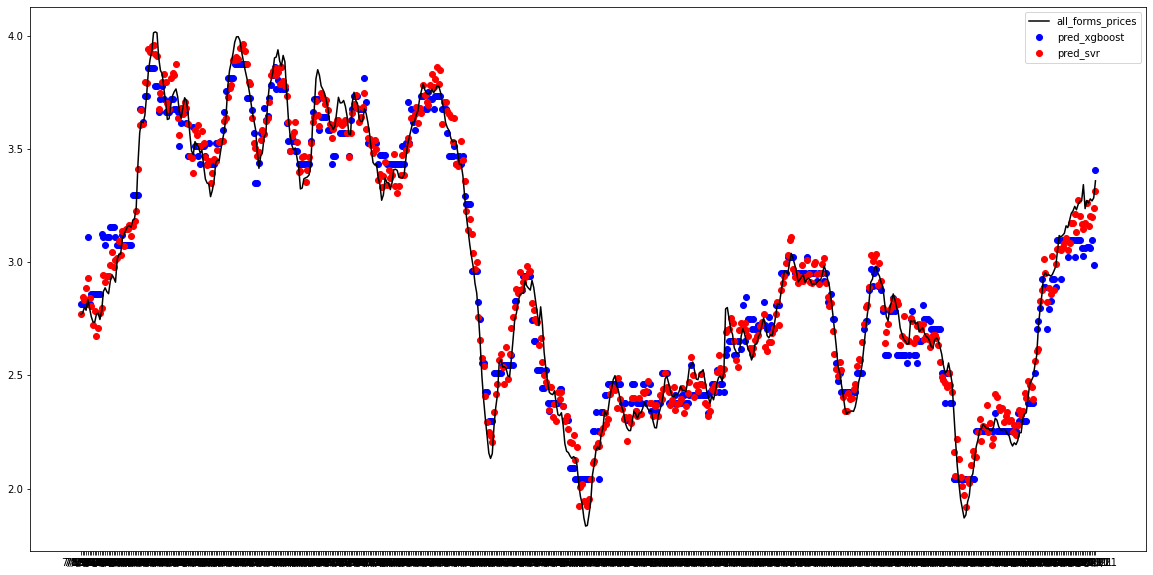

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(Weeks, pred_xgboost, label='pred_xgboost', color='blue')
ax.scatter(Weeks, pred_svr, label='pred_svr', color='red')
ax.plot(Weeks, All_Formulas_Prices, label='all_forms_prices', color='black')
ax.legend()

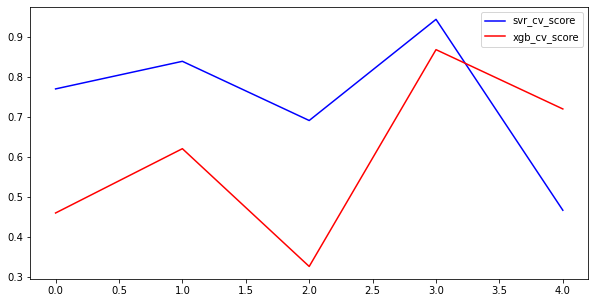

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
x_axis = list(range(0,len(svr_cv_score)))
ax.plot(x_axis, svr_cv_score, label='svr_cv_score', color='blue')
ax.plot(x_axis, xgb_cv_score, label='xgb_cv_score', color='red')
ax.legend()

In [19]:
residuals = pd.DataFrame(pred_svr-All_Formulas_Prices, pred_xgboost-All_Formulas_Prices)
residuals[1] = residuals.index
residuals['Week_of'] = Weeks
residuals.index = range(0,len(All_Formulas_Prices))
residuals = residuals.rename(columns={0:'SVR_Residual', 1:'XGB_Residual'})
print(residuals.SVR_Residual.mean(), residuals.SVR_Residual.std())
print(residuals.XGB_Residual.mean(), residuals.XGB_Residual.std())
residuals.head()

0.008901824932631228 0.06798627051272303
0.00025779939833141317 0.09936194934110705


,SVR_Residual,XGB_Residual,Week_of
0,-0.000814,0.045128,7/12/10
1,0.073161,0.041128,7/19/10
2,0.033671,0.015128,7/26/10
3,0.100047,0.028128,8/2/10
4,0.096094,0.277634,8/9/10


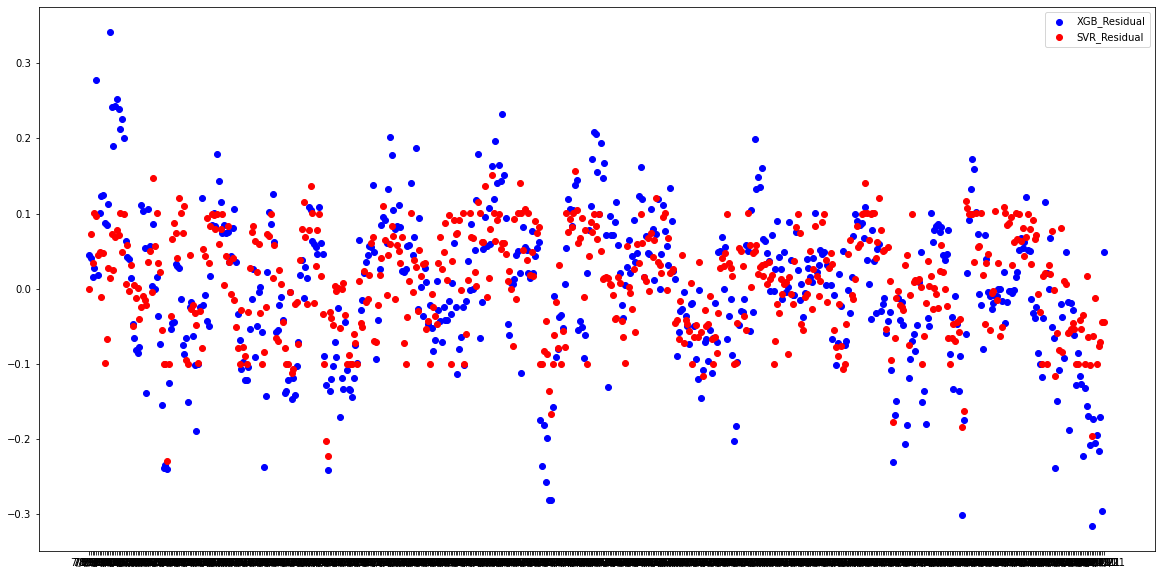

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(Weeks, residuals.XGB_Residual, label='XGB_Residual', color='blue')
ax.scatter(Weeks, residuals.SVR_Residual, label='SVR_Residual', color='red')
ax.legend()

In [21]:
rss_svr = np.sum(np.square(residuals.SVR_Residual))
print("RSS SVR = {}".format(rss_svr))
rss_xgb = np.sum(np.square(residuals.XGB_Residual))
print("RSS XGB = {}".format(rss_xgb))

RSS = 2.7597866406536684
RSS = 5.795370904211103
